In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from joblib import dump,load
import os
import sys
sys.path.append(os.getcwd() + '/modelos/')

### Prueba Evaluación Final

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


In [4]:
#import model_nb#modelo numero 1 de naive bayes
import model2_nb#modelo numero 2 de naive bayes

In [5]:
path = 'modelos/'

In [6]:
X = pd.read_csv('X_test.csv')
Y = pd.read_csv('Y_test.csv')

In [7]:
def getMetrics(preds):
    return {
            'accuracy':metrics.accuracy_score(preds,Y),
            'recall':metrics.recall_score(preds,Y),
            'precision':metrics.precision_score(preds,Y),
            'f1_score':metrics.f1_score(preds,Y)
            }

In [8]:
#función para retornar predicciones, Algoritmo de arbol de desición
def predictTree(X):
    from sklearn import tree
    tree_model = load(path+'tree_maxdept=4_class_weigth=None.joblib')
    tree.plot_tree(tree_model)
    preds = tree_model.predict(X)
    return preds

In [9]:
#función para retornar prediccion, Algoritmo de SVM
def predictSVM(X):
    svm = load(path+'svm_kernel=rbf_class_weitht=None.joblib')
    preds = svm.predict(X)
    return preds

In [10]:
#función para retornar predicciones, Algoritmo de Naive Bayes
def predictNB(X):
    preds = model2_nb.getPredicts(X)
    return preds

In [25]:
#función para retornar predicciones, Algoritmo de Regresión Logistica
def predictLR(X):
    #Restauramos la session guardada.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.import_meta_graph(path+'logistic_regression/model_lr-1001.meta')
        saver.restore(sess,tf.train.latest_checkpoint(path+'logistic_regression./'))
    
        y_hat = sess.run(["y_hat/Y_hat:0"], feed_dict={"X:0": X})
        probs = y_hat[0][:,1]
        preds = np.where(probs > 0.4, 1, 0)#umbral de 0.4
        return preds,probs

In [26]:
def predict(X):
    from scipy import stats as s
    tree = predictTree(X)
    svm = predictSVM(X)
    nb = predictNB(X)
    lr = predictLR(X) #se tarda mas al cargar el archivo de tensorflow  

    all_predictions = list(zip(lr[0],nb[0],tree,svm))
    
    predictions = [s.mode(x)[0][0] for x in all_predictions]
    
    return {
        'tree':tree,
        'svm':svm,
        'nb':nb[0],
        'lr':lr[0],
        'all_models':predictions
    },{'prob_lr':lr[1],'prob_nb':nb[1]}

In [27]:
def getDfMetrics(data):
    indexes = []
    columns = ['accuracy','recall','precision','f1_score']
    df = []
    for p in data:
        indexes.append(p)
        metrics = getMetrics(data[p])
        df.append(metrics)
    return pd.DataFrame(df,index=indexes)

INFO:tensorflow:Restoring parameters from modelos/logistic_regression./model_lr-1001


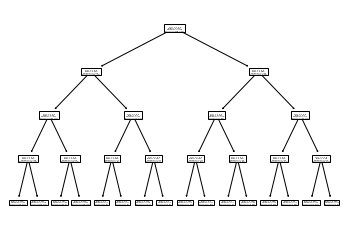

In [28]:
prediction = predict(X)

In [29]:
#obtener predicciones, predicciones vienen en el indice 0 y probabilidades de modelos probabilisticas en el indice 1
getDfMetrics(prediction[0])

,accuracy,recall,precision,f1_score
tree,0.815642,0.821429,0.666667,0.736000
svm,0.815642,0.821429,0.666667,0.736000
nb,0.804469,0.750000,0.739130,0.744526
lr,0.804469,0.750000,0.739130,0.744526
all_models,0.821229,0.877551,0.623188,0.728814


### Conclusiones
* Los modelos se encuentran dentro de los parametros establecidos, la exactitud mínima deseada es del 80%, se pueden construir modelos con mas exactitud dado la naturaleza del dataset que en su mayoría las personas no sobrevivieron, pero nos interesa mas buscar personas sobrevivientes, modelos arriba de 85% de exactitud logra identificar bien a las personas que murieron, sin embargo tiene muy baja sensibilidad para identificar sobrevivientes, por eso se logro balancear las metricas para poder encontrar un buen porcentaje entre sensibilidad y exactitud.


* Las predicciones finales de todos los modelos obtuvimos una exactitud del 82% y una sensibilidad de 87% nuestras métricas deseadas son aceptables, sin embargo la presición es de 62%, pero nos interesa mas indentificar personas que sobrevivieron.


* Es mejor decir que sobrevivió cuando en realidad no lo hizó a decir que no sobrevivió cuando en realidad si lo hizo


* Los mejores modelos en base a todas las metricas establecidas fueron los modelos probabilisticos, tanto regresión logistica como el de naive bayes




### Deployment

Probando nuestro modelo

In [30]:
def predictSurvived(X):
    prediction = predict(X)
    resp = prediction[0]['all_models'][0]
    probs = [prediction[1]['prob_lr'],prediction[1]['prob_nb']]
    return resp,probs

Forma de los parametros a enviar
* viaja_solo: si = 1, No = 0
* tarifa_de_0_100: especifica la tarifa pagada si esta entre 0 a 100, si = 1, No = 0
* tercera_clase: especifica si era pasaje de tercera clase, si = 1, No = 0
* femenino: especifica el genero femenino masculino si = 1 = femenino, No = 0 = masculino
* embarcacion_s: especifica el desembarque, si = 1, No = 0
* _a_20_años: especifica si el rango de edad esta entre 0 a 20 años, si = 1, No = 0

In [31]:
#prueba 10 observaciones
tests = np.array([
                    [1,0,0,1,0,1],
                    [1,1,1,1,1,1],
                    [0,0,0,1,0,1],
                    [1,0,0,1,0,1],
                    [1,0,0,0,1,1],
                    [0,0,1,1,0,0],
                    [1,1,1,0,1,1],
                    [0,1,1,0,1,0],
                    [1,1,1,0,1,1],
                    [0,1,1,1,0,0]
                ])
tests.shape

(10, 6)

INFO:tensorflow:Restoring parameters from modelos/logistic_regression./model_lr-1001

observacion No: 1

la ia dice que la persona Sobrevivió
regresión logistica: probabiliad de sobrevivir= 81.04%
naive bayes: probabiliad de No sobrevivir/sobrevivir= [ 1.58180498 98.41819502]%

INFO:tensorflow:Restoring parameters from modelos/logistic_regression./model_lr-1001

observacion No: 2

la ia dice que la persona Sobrevivió
regresión logistica: probabiliad de sobrevivir= 46.96%
naive bayes: probabiliad de No sobrevivir/sobrevivir= [30.99442817 69.00557183]%

INFO:tensorflow:Restoring parameters from modelos/logistic_regression./model_lr-1001

observacion No: 3

la ia dice que la persona Sobrevivió
regresión logistica: probabiliad de sobrevivir= 83.83%
naive bayes: probabiliad de No sobrevivir/sobrevivir= [ 0.70831671 99.29168329]%

INFO:tensorflow:Restoring parameters from modelos/logistic_regression./model_lr-1001

observacion No: 4

la ia dice que la persona Sobrevivió
regresión logistica: 

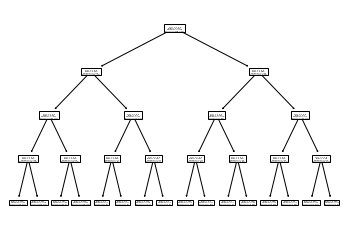

In [32]:
for i,t in enumerate(tests):
    resp = predictSurvived([t])
    print('\nobservacion No:',str(i+1))
    print('\nla ia dice que la persona '+('Sobrevivió' if resp[0] == 1 else 'No sobrevivió'))
    print('regresión logistica: probabiliad de sobrevivir=',str(round(resp[1][0][0] * 100,2))+'%')
    print('naive bayes: probabiliad de No sobrevivir/sobrevivir=',str(np.array(resp[1][1][0]) * 100)+'%\n')

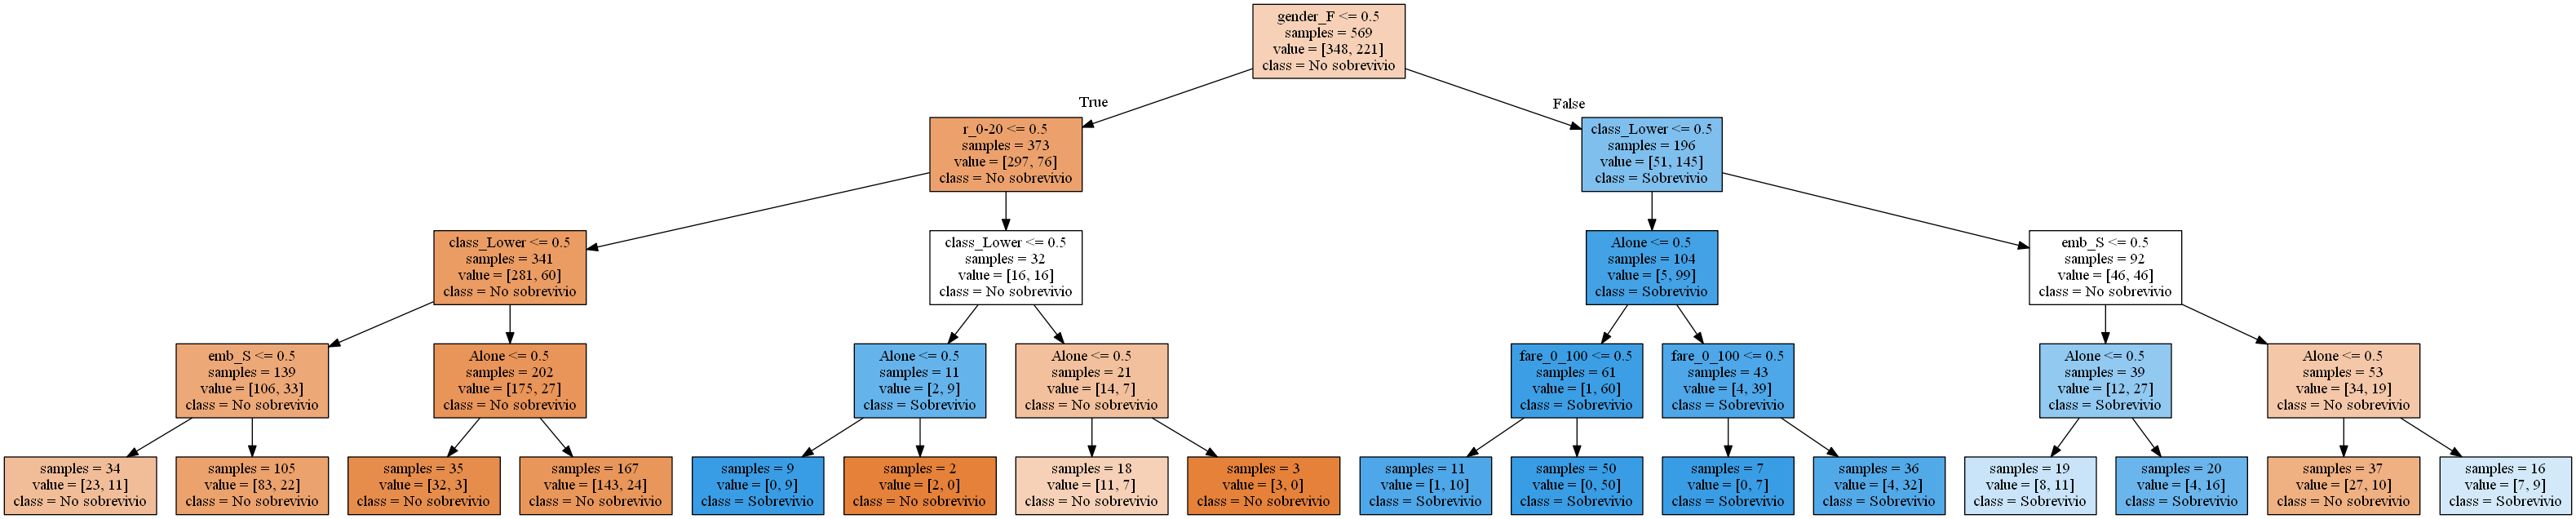

In [34]:
from IPython.display import Image
Image('modelos/arbol.png')